## Importing the CIFAR-100 dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import LabelBinarizer
# To ignore random tensorflow warnings.
import absl.logging
import matplotlib.pyplot as plt
absl.logging.set_verbosity(absl.logging.ERROR)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [3]:
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Thu May 18 14:01:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

## Data Augmentation

In [4]:
from keras.models import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

data_augment = Sequential([
    # Commented out when applying to testt data, because it's not deactivated at inference time
    # Rescaling(1./255),
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

enc = LabelBinarizer()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)
#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)

print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
print(x_test[0].shape)
print(y_test[0].shape)

(32, 32, 3)
(100,)


In [ ]:
def show_100_sample_images(images):
    fig, axes = plt.subplots(ncols=10, nrows=10)

    for ax, im in zip(axes.ravel(), images):
        ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
        ax.imshow(im)

    fig.show()

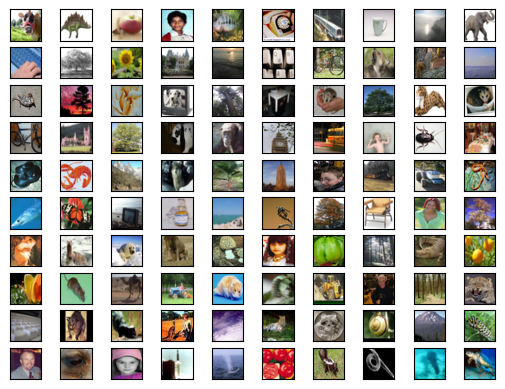

In [ ]:
#aug_ds = data_augment(x_train)

show_100_sample_images(x_train)
#show_100_sample_images(aug_ds)

## Inception v4 Implementation

The CIFAR100 dataset is composed of 32x32 pixel images as oppopsed to the 299x299 pixel images of the Imagenet network for which the Inceptionv4 network was originally comstructed. There a significant downsizing of the network is necessary to accomodate the 10x size difference.

Inception blocks are used to create feature maps, and reduction blocks are used to downsize the filter size for teh inception blocks
Intuitions:
1. Put 5x5 convolutions in stem to downsize image to smaller size, and expand filter space for the Inception-A blocks.
2. First inception blocks TRANSFORM the feature map (with 1x1 convolutions) while KEEPING the same image and filter size.
3. Reduction-A blocks further reduce the image size and expand filter space for Inception-B blocks.
4. Inception-B blocks further transform the feature map.
5. Probably not neccessary, but if it is add Reduction-B blocks
6. A final AveragePooling layer reduces  

1. Drop the reduction blocks as the image is already small adn there is no need to reduce image size (probably only dimension reduction is needed)
   1. this probably won't work as different size feature extraction is necessary
2. Reduce the number of Conv2DBatchNorm layers in each block (Inception, Reduction, Stem) in order not to decrease the image size down to one so quickly
3. Change all filter numbers to half.

10. Take design principles outlaid in the v3 paper into account

In [ ]:
#import tensorflow as tf
from keras.layers import Dense, Conv2D, Input, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Concatenate, Flatten
#from keras.layers import *
from keras import Model
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.initializers import VarianceScaling

# TODO: Go to Inceptionv2 paper to understand Conv2D_BN and fine tune parameters potentially
def Conv2DBatchNorm(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):

    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
               kernel_regularizer=l2(0.0005),
               kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def Stem(x):
    print("pre-stem size:", x.shape)

    x = Conv2DBatchNorm(x, 16, (3, 3))
    x = Conv2DBatchNorm(x, 32, (3, 3))

    branch_0 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    branch_1 = Conv2DBatchNorm(x, 48, (3, 3), strides=(2, 2), padding='valid')

    x = Concatenate()([branch_0, branch_1])
    
    branch_0 = Conv2DBatchNorm(x, 32, (1, 1))
    branch_0 = Conv2DBatchNorm(branch_0, 48, (3, 3), padding='valid')

    branch_1 = Conv2DBatchNorm(x, 32, (1, 1))
    branch_1 = Conv2DBatchNorm(branch_1, 32, (1, 7))
    branch_1 = Conv2DBatchNorm(branch_1, 32, (7, 1))
    branch_1 = Conv2DBatchNorm(branch_1, 48, (3, 3), padding='valid')

    x = Concatenate()([branch_0, branch_1])
    
    branch_0 = Conv2DBatchNorm(x, 96, (3, 3))

    # Here another reduction by half should occur according too inceptionv4, but it's too big a reduction so it's left off.
    branch_1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x = Concatenate()([branch_0, branch_1])

    print("post-stem size:", x.shape)

    return x


def InceptionA(x):
    print("pre-A size:", x.shape)

    branch_0 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_0 = Conv2DBatchNorm(branch_0, 48, (1, 1))

    branch_1 = Conv2DBatchNorm(x, 48, (1, 1))

    branch_2 = Conv2DBatchNorm(x, 32, (1, 1))
    branch_2 = Conv2DBatchNorm(branch_2, 48, (3, 3))

    branch_3 = Conv2DBatchNorm(x, 32, (1, 1))
    branch_3 = Conv2DBatchNorm(branch_3, 48, (3, 3))
    branch_3 = Conv2DBatchNorm(branch_3, 48, (3, 3))

    x = Concatenate()([branch_0, branch_1, branch_2, branch_3])
    print("post-A size:", x.shape)

    return x


def InceptionB(x):
    print("pre-B size:", x.shape)

    branch_0 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_0 = Conv2DBatchNorm(branch_0, 64, (1, 1))

    branch_1 = Conv2DBatchNorm(x, 192, (1, 1))

    branch_2 = Conv2DBatchNorm(x, 96, (1, 1))
    branch_2 = Conv2DBatchNorm(branch_2, 112, (1, 7))
    branch_2 = Conv2DBatchNorm(branch_2, 128, (7, 1))

    branch_3 = Conv2DBatchNorm(x, 96, (1, 1))
    branch_3 = Conv2DBatchNorm(branch_3, 96, (1, 7))
    branch_3 = Conv2DBatchNorm(branch_3, 112, (7, 1))
    branch_3 = Conv2DBatchNorm(branch_3, 112, (1, 7))
    branch_3 = Conv2DBatchNorm(branch_3, 128, (7, 1))

    x = Concatenate()([branch_0, branch_1, branch_2, branch_3])
    print("post-B size:", x.shape)

    return x


def InceptionC(x):
    print("pre-C size:", x.shape)

    branch_0 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_0 = Conv2DBatchNorm(branch_0, 128, (1, 1))

    branch_1 = Conv2DBatchNorm(x, 128, (1, 1))

    branch_2 = Conv2DBatchNorm(x, 192, (1, 1))
    branch_2_0 = Conv2DBatchNorm(branch_2, 128, (1, 3))
    branch_2_1 = Conv2DBatchNorm(branch_2, 128, (3, 1))

    branch_3 = Conv2DBatchNorm(x, 192, (1, 1))
    branch_3 = Conv2DBatchNorm(branch_3, 224, (1, 3))
    branch_3 = Conv2DBatchNorm(branch_3, 256, (3, 1))
    branch_3_0 = Conv2DBatchNorm(branch_3, 128, (3, 1))
    branch_3_1 = Conv2DBatchNorm(branch_3, 128, (1, 3))

    x = Concatenate()([branch_0, branch_1, branch_2_0, branch_2_1, branch_3_0, branch_3_1])
    print("post-C size:", x.shape)

    return x


def ReductionA(x):
    print("pre-RedA size:", x.shape)

    branch_0 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    branch_1 = Conv2DBatchNorm(x, 192, (3, 3), strides=(2, 2), padding='valid')

    branch_2 = Conv2DBatchNorm(x, 96, (1, 1))
    branch_2 = Conv2DBatchNorm(branch_2, 112, (3, 3))
    branch_2 = Conv2DBatchNorm(branch_2, 128, (3, 3), strides=(2, 2), padding='valid')

    x = Concatenate()([branch_0, branch_1, branch_2])
    print("post-RedA size:", x.shape)

    return x


def ReductionB(x):
    print("pre-RedB size:", x.shape)

    branch_0 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    branch_1 = Conv2DBatchNorm(x, 192, (1, 1))
    branch_1 = Conv2DBatchNorm(branch_1, 192, (2, 2), strides=(2, 2), padding='valid')

    branch_2 = Conv2DBatchNorm(x, 256, (1, 1))
    branch_2 = Conv2DBatchNorm(branch_2, 256, (1, 7))
    branch_2 = Conv2DBatchNorm(branch_2, 320, (7, 1))
    branch_2 = Conv2DBatchNorm(branch_2, 320, (2, 2), strides=(2, 2), padding='valid')

    x = Concatenate()([branch_0, branch_1, branch_2])
    print("post-RedB size:", x.shape)

    return x


def MyInception():
    inputs = Input(shape=(32, 32, 3), name='input')

    #x = data_augment(inputs)
    x = Stem(inputs)

    for _ in range(4):
        x = InceptionA(x)

    x = ReductionA(x)

    for _ in range(2):
        x = InceptionB(x)

    x = ReductionB(x)

    for _ in range(1):
        x = InceptionC(x)

    x = AveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)

    outputs = Dense(100, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=outputs, name='MyInception')

    return model


model = MyInception()




pre-stem size: (None, 32, 32, 3)
post-stem size: (None, 13, 13, 192)
pre-A size: (None, 13, 13, 192)
post-A size: (None, 13, 13, 192)
pre-A size: (None, 13, 13, 192)
post-A size: (None, 13, 13, 192)
pre-A size: (None, 13, 13, 192)
post-A size: (None, 13, 13, 192)
pre-A size: (None, 13, 13, 192)
post-A size: (None, 13, 13, 192)
pre-RedA size: (None, 13, 13, 192)
post-RedA size: (None, 6, 6, 512)
pre-B size: (None, 6, 6, 512)
post-B size: (None, 6, 6, 512)
pre-B size: (None, 6, 6, 512)
post-B size: (None, 6, 6, 512)
pre-RedB size: (None, 6, 6, 512)
post-RedB size: (None, 3, 3, 1024)
pre-C size: (None, 3, 3, 1024)
post-C size: (None, 3, 3, 768)


In [ ]:
from keras.metrics import TopKCategoricalAccuracy
from keras.optimizers import Adam

model.compile(Adam(),
              loss='categorical_crossentropy',
              metrics=[
                  TopKCategoricalAccuracy(k=1, name='top_1_accuracy'),
                  TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
              ])

print("Number of paramteres:", model.count_params())

Number of paramteres: 5741188


Notes:

The Stem Reduces image size from 299 to 35 in the original Inceptionv4 architecture which is a 1/10 scale. That is too large of a downscale and we can't afford that with a 32 by 32 image. That's why my stem only reduces image 1/3. I've also reduced all teh filter numbers to half their original number, because presumably for a smaller mage a smaller repsresentation will be sufficient

(2, 2) kernel and pool size is weird in redB block. Should try to fix stem size reduction somehow to get a bit bigger input dimensions to redB.

Questions:
What metrics to use
What to log
How many blocks to use

In [11]:
!pip install pyNVML
import pynvml as nvidia_smi

def get_max_batch_size(model, image_size, inference=False):
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    total_gpu_memory = info.total
    # Weights are float32 -> 4 bytes
    model_size = model.count_params() * 4
    # Rescaling layer returns float32
    # 299*299 pixels, RGB colors
    image_bytes = 4 * image_size * image_size * 3
    if inference:
        MAX_BATCH_SIZE = int(np.floor((total_gpu_memory - model_size) / image_bytes))
    else:
        MAX_BATCH_SIZE = int(np.floor(total_gpu_memory / (model_size + image_bytes)))
    MAX_BATCH_SIZE_LOG2 = int(2 ** np.floor(np.log2(MAX_BATCH_SIZE)))
    # print(MAX_BATCH_SIZE)
    # print(MAX_BATCH_SIZE_LOG2)
    return MAX_BATCH_SIZE, MAX_BATCH_SIZE_LOG2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, TerminateOnNaN
import datetime

logdir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model.fit(x_train, y_train,
          batch_size=MAX_BATCH_SIZE_LOG2,
          epochs=200,
          validation_split=0.2,
          validation_batch_size=MAX_BATCH_SIZE_LOG2,
          verbose=1,
          callbacks=[
              TensorBoard(
                  log_dir=logdir,
                  histogram_freq=1
              ),
              EarlyStopping(
                  monitor='val_top_1_accuracy',
                  patience=10,
                  restore_best_weights=True,
              ),
              ModelCheckpoint(
                  logdir+'/checkpoint',
                  monitor='val_top_1_accuracy',
                  save_best_only=True,
              ),
              TerminateOnNaN(),
          ],
          )


Epoch 1/200
79/79 [==============================] - 119s 1s/step - loss: 11.0252 - top_1_accuracy: 0.0972 - top_5_accuracy: 0.2792 - val_loss: 10.8472 - val_top_1_accuracy: 0.0279 - val_top_5_accuracy: 0.1235
Epoch 2/200
79/79 [==============================] - 81s 1s/step - loss: 8.9354 - top_1_accuracy: 0.1964 - top_5_accuracy: 0.4662 - val_loss: 8.8458 - val_top_1_accuracy: 0.1034 - val_top_5_accuracy: 0.3088
Epoch 3/200
79/79 [==============================] - 81s 1s/step - loss: 7.4294 - top_1_accuracy: 0.2662 - top_5_accuracy: 0.5702 - val_loss: 7.7102 - val_top_1_accuracy: 0.1522 - val_top_5_accuracy: 0.3869
Epoch 4/200
79/79 [==============================] - 82s 1s/step - loss: 6.3448 - top_1_accuracy: 0.3245 - top_5_accuracy: 0.6415 - val_loss: 6.8537 - val_top_1_accuracy: 0.1802 - val_top_5_accuracy: 0.4395
Epoch 5/200
79/79 [==============================] - 80s 1s/step - loss: 5.5237 - top_1_accuracy: 0.3787 - top_5_accuracy: 0.7023 - val_loss: 6.2909 - val_top_1_accuracy

In [ ]:
%load_ext tensorboard

Miert gyorsul fel a tanitas

In [ ]:
%tensorboard --logdir ./logs/fit

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=1024)
print(results)

10/10 [==============================] - 2s 213ms/step - loss: 4.3643 - top_1_accuracy: 0.4153 - top_5_accuracy: 0.7119
[4.364299774169922, 0.41530001163482666, 0.711899995803833]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorboard --logdir ./drive/MyDrive/colab_buffer

In [7]:
from keras.models import load_model

base_model = load_model('./drive/MyDrive/colab_buffer/myinception-without-aug/fit/20230510-113441/checkpoint')
aug_model = load_model('./drive/MyDrive/colab_buffer/data aug logs/logs/fit/20230423-141037/checkpoint/')
more_aug_model = load_model('./drive/MyDrive/colab_buffer/more-images-data-aug/fit/20230426-160956/checkpoint/')

In [7]:
base_model_eval = base_model.evaluate(x_test, y_test)
aug_model_eval = aug_model.evaluate(x_test, y_test)
more_aug_model_eval = more_aug_model.evaluate(x_test, y_test)

print(base_model_eval)
print(aug_model_eval)
print(more_aug_model_eval)

313/313 [==============================] - 89s 274ms/step - loss: 3.0706 - top_1_accuracy: 0.5329 - top_5_accuracy: 0.8092
[4.3643012046813965, 0.41530001163482666, 0.711899995803833]
[2.671558141708374, 0.48570001125335693, 0.786899983882904]
[3.070625066757202, 0.5328999757766724, 0.8091999888420105]


In [20]:
pred_1 = aug_model.predict(x_test[:5])
pred_2 = aug_model.predict(data_augment(x_test[:5]))

print(np.argmax(pred_1, axis=1), np.argmax(pred_2, axis=1))

1/1 [==============================] - 1s 1s/step
[49 80 72 51 71] [49  4 72 51 71]


In [13]:
# Steps:
# Do for all 3 models
# 1. evaluate
# 2. transform 
# 3. evaluate transformed
# repeat 2. and 3.
def evaluate_certainty(model, n_transforms=10):
    # 10000x100
    base_results = model.predict(x_test, batch_size=get_max_batch_size(model, 32, True)[1])
    # n_transormsx10000x100
    results_after_transform = [base_results]

    for _ in range(n_transforms):
        x_transformed = data_augment(x_test)
        results_after_transform.append(model.predict(x_transformed, batch_size=get_max_batch_size(model, 32, True)[1]))

    results_after_transform = np.array(results_after_transform)
    # 10000x2(#unique, #unique)
    counts = []

    for i in range(len(x_test)):
        elements = results_after_transform[:, i, :]
        counts.append(np.unique(np.argmax(elements, axis=1), return_counts=True, axis=0))

    # 10000x1
    certainties = []

    for i in range(len(counts)):
        idx = np.where(counts[i][0] == np.argmax(base_results[i]))[0][0]
        # + 1 is needed because we also put the base_reults into the results_after_transform list
        certainty = counts[i][1][idx] / (n_transforms + 1)
        certainties.append(certainty)

    overall_certainty = np.mean(certainties)

    return overall_certainty



In [12]:
get_max_batch_size(base_model, 32, True)

(1308851, 1048576)

In [14]:
print("Calculating base model certainty")
base_model_certainty = evaluate_certainty(base_model, 100)
print("Calculating aug model certainty")
aug_model_certainty = evaluate_certainty(aug_model, 100)
print("Calculating more aug model certainty")
more_aug_model_certainty = evaluate_certainty(more_aug_model, 100)

print(f'Base model certainty: {round(base_model_certainty * 100, 2)}%')
print(f'Model certainty with augmentation: {round(aug_model_certainty * 100, 2)}%')
print(f'Model certainty with multiplied data and augmentation: {round(more_aug_model_certainty * 100, 2)}%')

Calculating base model certainty
1/1 [==============================] - 0s 165ms/step


KeyboardInterrupt: ignored